In [49]:
#библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as ps
import plotly.graph_objects as go
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

import statsmodels.api as sm


df = pd.read_csv("DataSet3_2.csv", sep=";")
#df = df.drop(columns=['pc'], axis=1)
df['Data'] = pd.to_datetime(df['Data'], format="%d.%m.%Y")
df['Seconds'] = df['Data'].apply(lambda x: int(x.timestamp()))
df['Dollar']=df['Dollar'].str.replace(',', '.').astype(float).round()
df['Oil Brent']=df['Oil Brent'].str.replace(',', '.').astype(float).round()
df.head()

,Data,Dollar,Oil Brent,Seconds
0,2020-01-01,62.0,66.0,1577836800
1,2020-01-09,62.0,65.0,1578528000
2,2020-01-10,61.0,65.0,1578614400
3,2020-01-11,61.0,65.0,1578700800
4,2020-01-14,61.0,64.0,1578960000


In [50]:
#новый дс
df2 = pd.DataFrame()
df2['x'] = df.Seconds[10:130].to_numpy()
df2['y'] = df.Dollar[10:130].to_numpy()
df2['p1'] = df['Oil Brent'][10:130].to_numpy()
df2['p2'] = df.Dollar[9:129].to_numpy() #шаг назад

# % на выборках
oby4 = round(0.8*(130-10))
train = df2[:oby4]
test = df2[oby4:]
# Извлечение признаков и целевой переменной из обучающих данных
X_train = train.drop(['y'], axis=1, inplace=False)
y_train = train.y

X_test = test.drop(['y'], axis=1, inplace=False)
y_test = test.y

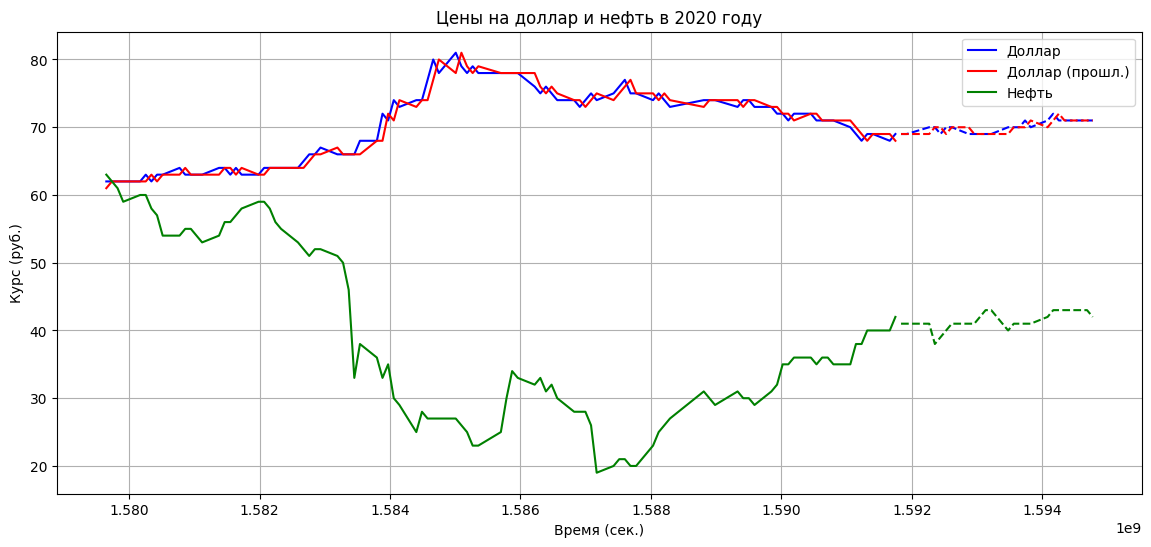

In [51]:

fig = go.Figure()

plt.figure(figsize=(14, 6))
plt.plot(train['x'], train['y'], color = 'blue', label='Доллар', linestyle = 'solid')
plt.plot(test['x'], test['y'], color = 'blue',linestyle = 'dashed')
plt.plot(train['x'], train['p2'], color = 'red', label='Доллар (прошл.)', linestyle = 'solid')
plt.plot(test['x'], test['p2'], color = 'red',linestyle = 'dashed')
plt.plot(train['x'], train['p1'], color = 'green', label='Нефть', linestyle = 'solid')
plt.plot(test['x'], test['p1'], color = 'green',linestyle = 'dashed')
plt.xlabel('Время (сек.)')
plt.ylabel('Курс (руб.)')
plt.title('Цены на доллар и нефть в 2020 году')
plt.grid()
plt.legend()
plt.show()


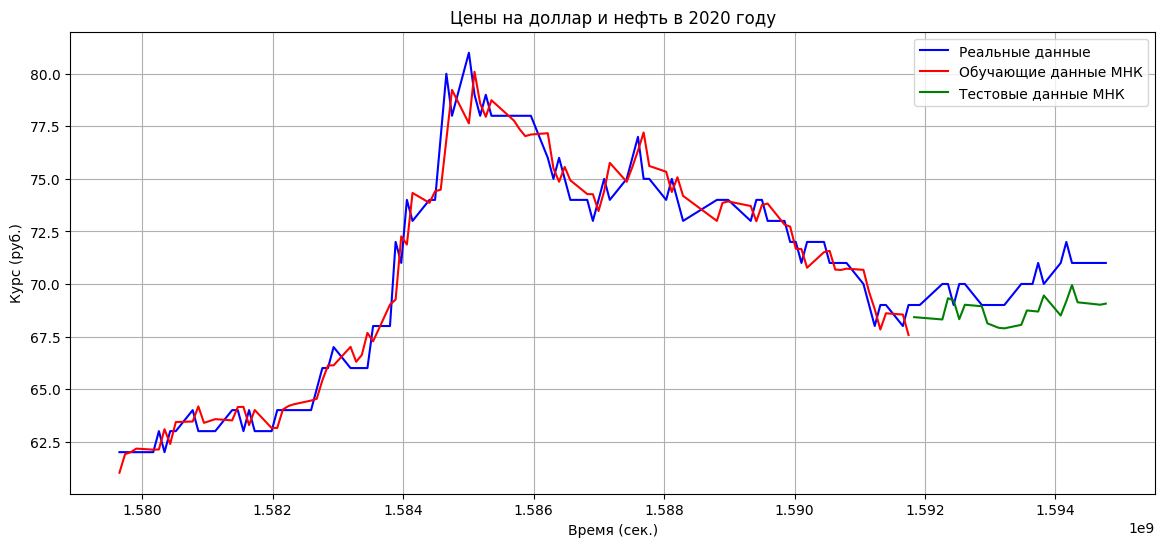

RMSE МНК обучающая: 1.02
RMSE МНК тестовая: 1.51


In [52]:
#Метод МНК (квадратичная гипотеза)

# Определение функции для квадратичной аппроксимации
def func(data, c0, c1, c2, c3, c4):
    return (c0 + c1 * data['x'] + c2 * data['x']**2) + c3 * data['p1'] + c4 * data['p2']

# Выполнение метода наименьших квадратов
popt, _ = curve_fit(func, X_train, y_train)
c0, c1, c2, c3, c4 = popt[0], popt[1], popt[2], popt[3], popt[4]

#распаковка
y_train_MHK= func(X_train, c0, c1, c2, c3, c4)
y_test_MHK = func(X_test, c0, c1, c2, c3, c4)

plt.figure(figsize=(14, 6))
plt.plot(df2['x'], df2['y'], color = 'blue', label='Реальные данные', linestyle = 'solid')
plt.plot(train['x'], y_train_MHK, color = 'red', label='Обучающие данные МНК', linestyle = 'solid')
plt.plot(test['x'], y_test_MHK, color = 'green', label='Тестовые данные МНК', linestyle = 'solid')

plt.xlabel('Время (сек.)')
plt.ylabel('Курс (руб.)')
plt.title('Цены на доллар и нефть в 2020 году')
plt.grid()
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error as RMSE

#rmse = np.sqrt(mean_squared_error(y_test, y_test_MHK))
#print(f'RMSE МНК: {rmse:.2f}')

# Расчет RMSE для МНК
rmse = RMSE(train['y'],y_train_MHK,squared=False)
print(f'RMSE МНК обучающая: {rmse:.2f}')

rmse = RMSE(test['y'],y_test_MHK,squared=False)
print(f'RMSE МНК тестовая: {rmse:.2f}')

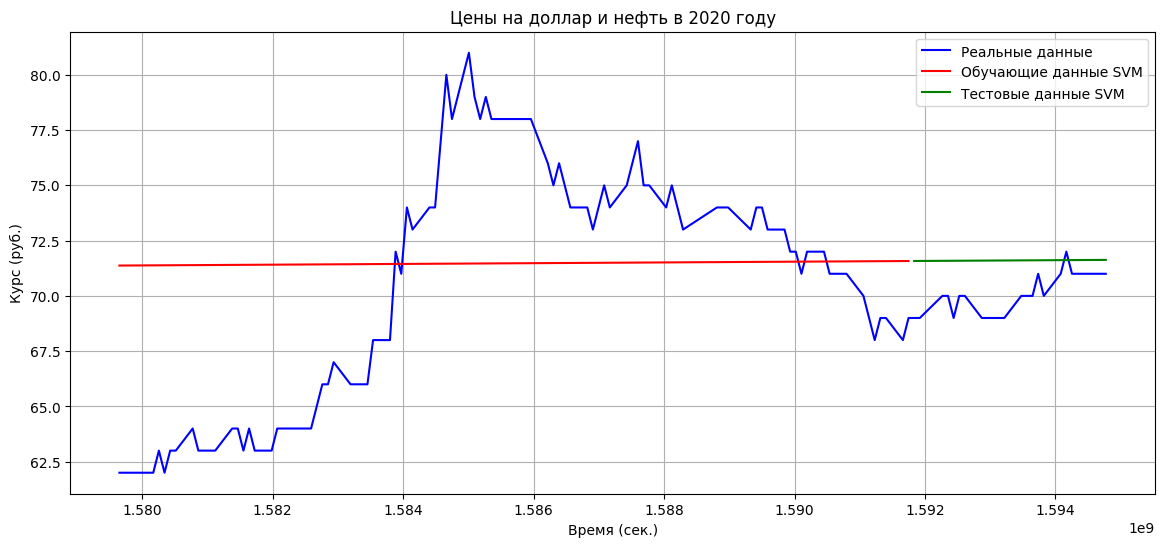

RMSE SVM обучающая: 5.52
RMSE SVM тестовая: 1.79


In [53]:
#SVM

from sklearn.svm import SVR #опорные вектора
model = SVR(kernel = 'rbf', degree=2, C=100, epsilon=0.1)  # создание модели с линейным ядром
model.fit(X_train, y_train)  # обучение модели

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

plt.figure(figsize=(14, 6))
plt.plot(df2['x'], df2['y'], color = 'blue', label='Реальные данные', linestyle = 'solid')
plt.plot(train['x'], y_train_pred, color = 'red', label='Обучающие данные SVM', linestyle = 'solid')
plt.plot(test['x'], y_test_pred, color = 'green', label='Тестовые данные SVM', linestyle = 'solid')

plt.xlabel('Время (сек.)')
plt.ylabel('Курс (руб.)')
plt.title('Цены на доллар и нефть в 2020 году')
plt.grid()
plt.legend()
plt.show()

# Расчет RMSE для SVM
rmse = RMSE(train['y'],y_train_pred,squared=False)
print(f'RMSE SVM обучающая: {rmse:.2f}')

rmse = RMSE(test['y'],y_test_pred,squared=False)
print(f'RMSE SVM тестовая: {rmse:.2f}')

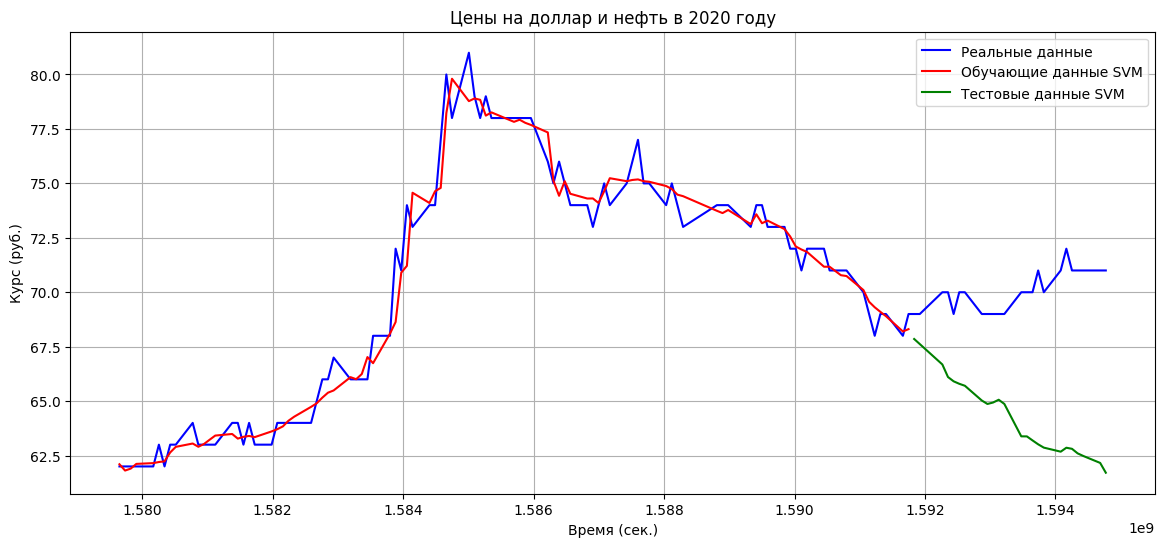

RMSE SVM обучающая: 0.86
RMSE SVM тестовая: 6.24


In [54]:
# SVM

from sklearn.preprocessing import StandardScaler
# Создание и обучение модели SVR
scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train)
X_test2 = scaler.transform(X_test)

from sklearn.svm import SVR #опорные вектора
model = SVR(kernel = 'rbf', degree=2, C=100, epsilon=0.1)  # создание модели с линейным ядром
model.fit(X_train2, y_train)  # обучение модели

y_train_pred = model.predict(X_train2)
y_test_pred = model.predict(X_test2)

plt.figure(figsize=(14, 6))
plt.plot(df2['x'], df2['y'], color = 'blue', label='Реальные данные', linestyle = 'solid')
plt.plot(train['x'], y_train_pred, color = 'red', label='Обучающие данные SVM', linestyle = 'solid')
plt.plot(test['x'], y_test_pred, color = 'green', label='Тестовые данные SVM', linestyle = 'solid')

plt.xlabel('Время (сек.)')
plt.ylabel('Курс (руб.)')
plt.title('Цены на доллар и нефть в 2020 году')
plt.grid()
plt.legend()
plt.show()

# Расчет RMSE для SVM
rmse = RMSE(train['y'],y_train_pred,squared=False)
print(f'RMSE SVM обучающая: {rmse:.2f}')

rmse = RMSE(test['y'],y_test_pred,squared=False)
print(f'RMSE SVM тестовая: {rmse:.2f}')

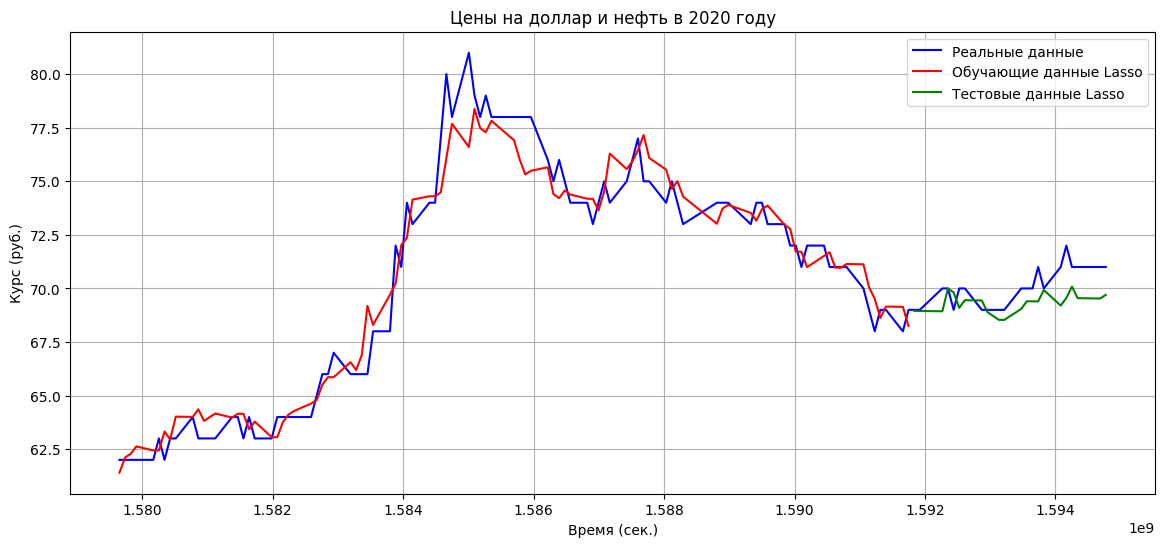

RMSE Lasso обучающая: 1.19
RMSE Lasso тестовая: 1.04


In [55]:
#метод Лассо

from sklearn.linear_model import Lasso

# Создание модели Lasso
model = Lasso(alpha=2.0)  # alpha - параметр регуляризации
# Обучение модели
model.fit(X_train, y_train)

y_train_lasso = model.predict(X_train)
y_test_lasso = model.predict(X_test)

plt.figure(figsize=(14, 6))
plt.plot(df2['x'], df2['y'], color = 'blue', label='Реальные данные', linestyle = 'solid')
plt.plot(train['x'], y_train_lasso, color = 'red', label='Обучающие данные Lasso', linestyle = 'solid')
plt.plot(test['x'], y_test_lasso, color = 'green', label='Тестовые данные Lasso', linestyle = 'solid')

plt.xlabel('Время (сек.)')
plt.ylabel('Курс (руб.)')
plt.title('Цены на доллар и нефть в 2020 году')
plt.grid()
plt.legend()
plt.show()


rmse = RMSE(train['y'],y_train_lasso,squared=False)
print(f'RMSE Lasso обучающая: {rmse:.2f}')

rmse = RMSE(test['y'],y_test_lasso,squared=False)
print(f'RMSE Lasso тестовая: {rmse:.2f}')


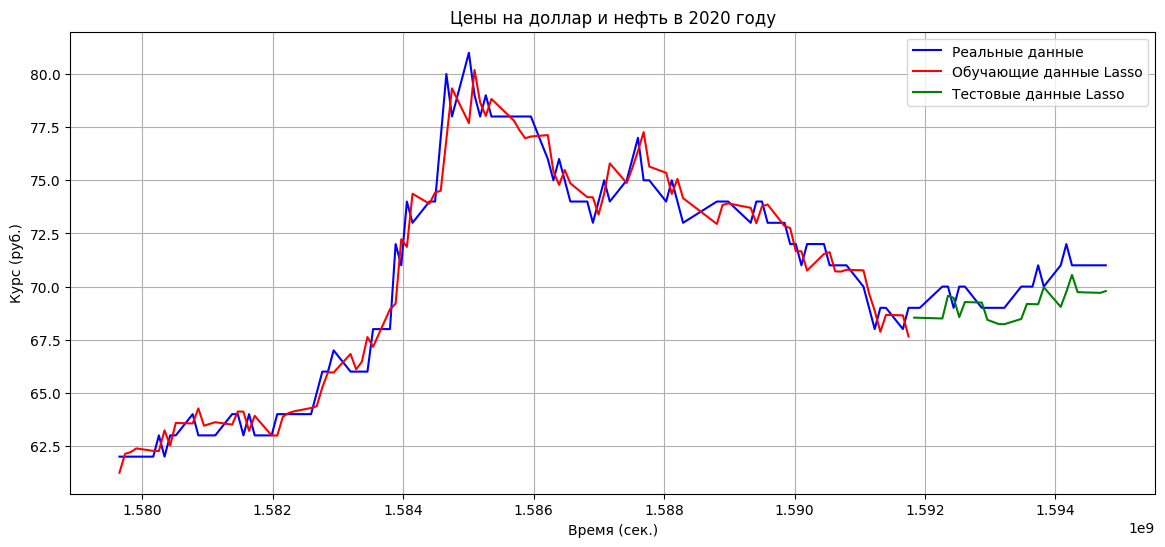

RMSE PLS обучающая: 1.02
RMSE PLS тестовая: 1.12


In [57]:
from sklearn.cross_decomposition import PLSRegression

# Создание модели PLS с указанием количества компонент (n_components)
model = PLSRegression(n_components=3)

# Обучение модели
model.fit(X_train, y_train)

y_train_PLS = model.predict(X_train)
y_test_PLS = model.predict(X_test)

plt.figure(figsize=(14, 6))
plt.plot(df2['x'], df2['y'], color = 'blue', label='Реальные данные', linestyle = 'solid')
plt.plot(train['x'], y_train_PLS, color = 'red', label='Обучающие данные Lasso', linestyle = 'solid')
plt.plot(test['x'], y_test_PLS, color = 'green', label='Тестовые данные Lasso', linestyle = 'solid')

plt.xlabel('Время (сек.)')
plt.ylabel('Курс (руб.)')
plt.title('Цены на доллар и нефть в 2020 году')
plt.grid()
plt.legend()
plt.show()


rmse = RMSE(train['y'],y_train_PLS,squared=False)
print(f'RMSE PLS обучающая: {rmse:.2f}')

rmse = RMSE(test['y'],y_test_PLS,squared=False)
print(f'RMSE PLS тестовая: {rmse:.2f}')